In [12]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt

In [5]:
# Downloading CIFAR-10 dataset
data_path = "../data-unverioned/p1c7/"
# Instantiates a dataset for the training data;
# TorchVision downloads the data if it is not present
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
# With train=False, this gets us a dataset for the validation data,
# again downloading as necessary.
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Extracting ../data-unverioned/p1c7/cifar-10-python.tar.gz to ../data-unverioned/p1c7/
Files already downloaded and verified


The first argument we provide to the CIFAR10 function is the location from which the data will be downloaded; the second specifies whether we’re interested in the training set or the validation set; and the third says whether we allow PyTorch to download the data if it is not found in the location specified in the first argument.

Just like CIFAR10, the datasets submodule gives us precanned access to the most popular computer vision datasets, such as MNIST, Fashion-MNIST, CIFAR-100, SVHN, Coco, and Omniglot. In each case, the dataset is returned as a subclass of *torch.utils.data.Dataset*

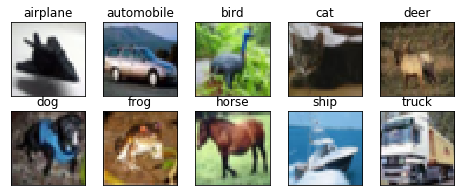

In [15]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    # The next() function returns the next item from the iterator.
    plt.imshow(img)
plt.show()


**The Dataset Class**

It’s a good time to discover what being a subclass of torch.utils.data.Dataset means in practice. Looking at figure 7.2, we see what PyTorch Dataset is all about. It is an object that is required to implement two methods: __len__ and __getitem__. The former should return the number of items in the dataset; the latter should return the item, consisting of a sample and its corresponding label (an integer index). In practice, when a Python object is equipped with the __len__ method, we can pass it as an argument to the len Python built-in function:

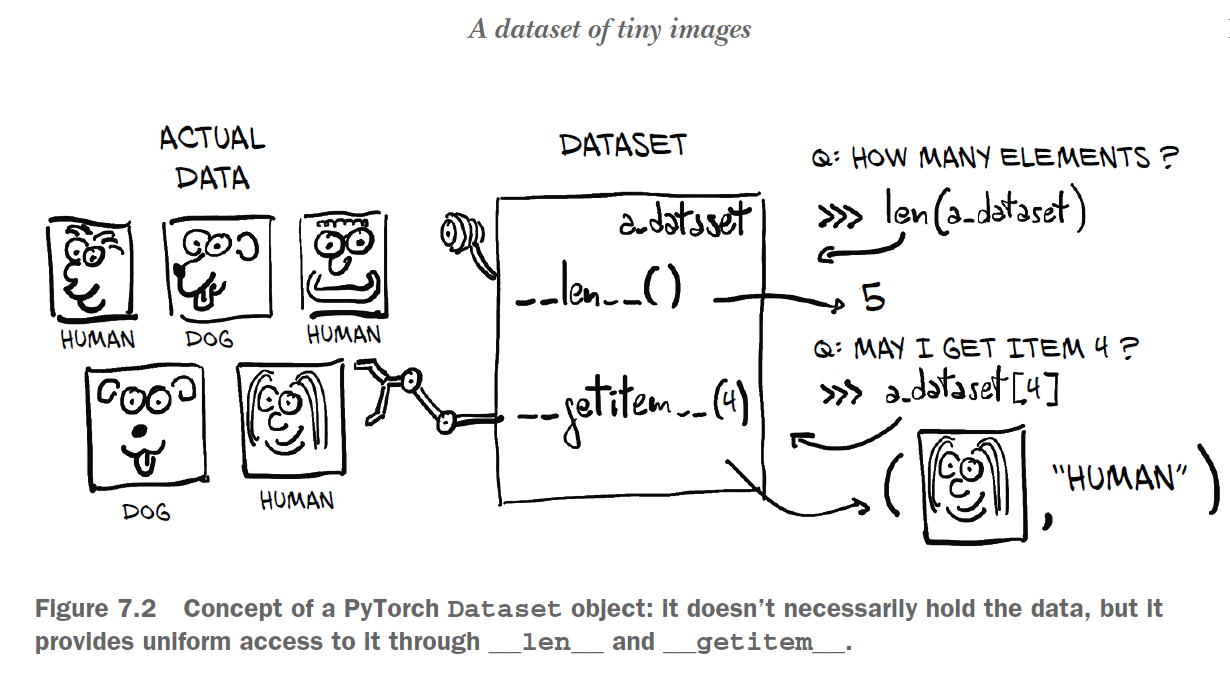

In [8]:
len(cifar10), len(cifar10_val)

(50000, 10000)

In [32]:
img,label = cifar10[99]
img,label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x11378B65788>, 1, 'automobile')

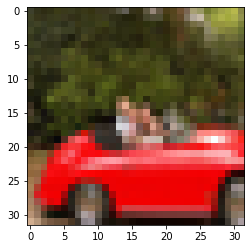

In [33]:
plt.imshow(img)
plt.show()

#### Converting PIL image to Tensor
But we’ll likely need a way to convert the PIL image to a PyTorch
tensor before we can do anything with it. That’s where torchvision.transforms
comes in. This module defines a set of composable, function-like objects that can be
passed as an argument to a torchvision dataset such as datasets.CIFAR10(…), and
that perform transformations on the data after it is loaded but before it is returned by
__getitem__. We can see the list of available objects as follows:

In [19]:
# List of available transforms
from torchvision import transforms
print(dir(transforms))

['CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'FiveCrop', 'Grayscale', 'Lambda', 'LinearTransformation', 'Normalize', 'PILToTensor', 'Pad', 'RandomAffine', 'RandomApply', 'RandomChoice', 'RandomCrop', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomOrder', 'RandomPerspective', 'RandomResizedCrop', 'RandomRotation', 'RandomSizedCrop', 'RandomVerticalFlip', 'Resize', 'Scale', 'TenCrop', 'ToPILImage', 'ToTensor', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'functional', 'functional_pil', 'functional_tensor', 'transforms']


Among those transforms, we can spot ToTensor, which turns NumPy arrays and PIL images to tensors. It also takes care to lay out the dimensions of the output tensor as C × H × W (channel, height, width).

Let’s try out the __ToTensor__ transform. Once instantiated, it can be called like a
function with the PIL image as the argument, returning a tensor as output

In [21]:
img_t_transforms = transforms.ToTensor()
img_t = img_t_transforms(img)
img_t.shape

torch.Size([3, 32, 32])

As we anticipated, we can pass the transform directly as an argument to **dataset.CIFAR10**:

In [22]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
transform=transforms.ToTensor())

At this point, accessing an element of the dataset will return a tensor, rather than a
PIL image

In [29]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [38]:
print(img_t.shape, img_t.dtype)
# changing the shape of the image
img_t = img_t.permute(1, 2, 0)
print(img_t.shape, img_t.dtype)

torch.Size([3, 32, 32]) torch.float32
torch.Size([32, 32, 3]) torch.float32


Whereas the values in the original PIL image ranged from 0 to 255 (8 bits per channel), the ToTensor transform turns the data into a 32-bit floating-point per channel, scaling the values down from 0.0 to 1.0. Let’s verify that:

In [39]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

#### Normalizing image data

In order to make it so that each channel has zero mean and unitary standard deviation, we can compute the mean value and the standard deviation of each channel across the dataset and apply the following transform: v_n[c] = (v[c] - mean[c]) /stdev[c]. This is what transforms.Normalize does. The values of mean and stdev must be computed offline (they are not computed by the transform). Let’s compute them for the CIFAR-10 training set:

Let’s stack all the tensors returned by the dataset along an extra dimension:

In [55]:
imgs = torch.stack([img_t for img_t,_ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

Now we can easily compute the mean per channel:

In [58]:
print(imgs.view(3, -1).shape)
imgs.view(3, -1).mean(1)

torch.Size([3, 51200000])


tensor([0.4915, 0.4823, 0.4468])

In [61]:
# Computing the standard deviation is similar:
imgs.view(3, -1).mean(1)
print(imgs.view(3, -1).shape)
imgs.view(3, -1).std(1)

torch.Size([3, 51200000])


tensor([0.2470, 0.2435, 0.2616])

With these numbers in our hands, we can initialize the Normalize transform

In [62]:
transforms.Normalize(mean=(0.4915, 0.4823, 0.4468),
                    std=(0.4915, 0.4823, 0.4468))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.4915, 0.4823, 0.4468))

Concatenate it after the **ToTensor** transform and add it to dataset object

In [66]:
transformed_cifar10 = datasets.CIFAR10(data_path, 
                                       train=True,
                                       download=True,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(
                                               mean=(0.4915, 0.4823, 0.4468),
                                               std=(0.4915, 0.4823, 0.4468))
                                       ]))

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


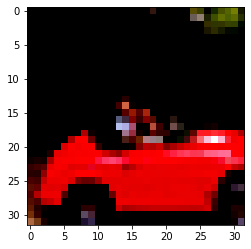

In [70]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

The renormalized red car we get is shown in figure 7.5. This is because normalization has shifted the RGB levels outside the 0.0 to 1.0 range and changed the overall magnitudes of the channels. All of the data is still there; it’s just that Matplotlib renders it as black. We’ll keep this in mind for the future.

In [73]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
                              transform = transforms.ToTensor())

Files already downloaded and verified


In [74]:
imgs_val = torch.stack([img_t for img_t, _ in cifar10_val], dim=3)
imgs_val.shape

torch.Size([3, 32, 32, 10000])

In [75]:
imgs_val.view(3, -1).mean(1)

tensor([0.4943, 0.4852, 0.4506])

In [76]:
imgs_val.view(3, -1).std(1)

tensor([0.2467, 0.2429, 0.2616])

There’s a good reason behind the input convention: taking
the logarithm of a probability is tricky when the probability gets close to zero. The
workaround is to use nn.LogSoftmax instead of nn.Softmax, which takes care to make
the calculation numerically stable.

In [77]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

NameError: name 'nn' is not defined